In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
from glob import glob
import scipy.integrate as integrate
import pickle as pkl

import taurunner as tr
from taurunner.utils import units

%matplotlib inline

## Define your input spectrum energy and flux arrays (Energy in $GeV$ and flux is $E^{2} \Phi$ in $\rm{GeV}\, \rm{cm}^{-2}\, \rm{s^{-1}}\, \rm{sr^{-1}}$ ) ##

In [2]:
File = np.genfromtxt(f'{tr.__path__[0]}/resources/ahlers2010.csv', delimiter = ',')

gzk_en = File[0]*units.GeV
gzk_flux = File[1]*units.GeV

gzk_mine = gzk_en[0]
gzk_maxe = gzk_en[-1]

## Spline the flux ##

NameError: name 'gzk_min' is not defined

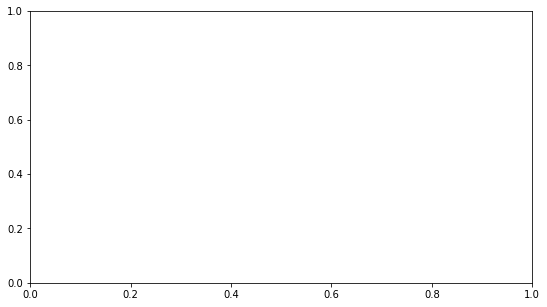

In [3]:
gzk_spline   = UnivariateSpline(np.log10(gzk_en), np.log10(gzk_flux/gzk_en**2), k = 4, s=1e-2)

fig, ax      = plt.subplots(figsize = (9,5))
test_log_ens = np.linspace(np.log10(gzk_mine), np.log10(gzk_max+0.3), 500)


plt.scatter(gzk_en/units.GeV, gzk_flux/gzk_en**2, lw = 8., alpha = 0.4, label = 'Model')
plt.plot(np.power(10, test_log_ens)/units.GeV, np.power(10., gzk_spline(test_log_ens)), label = 'Spline')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$d\Phi / dE_{\nu}$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
plt.legend(loc=8, fontsize = 16)
fig.set_facecolor('w')

plt.show()

## Define the probability function ##

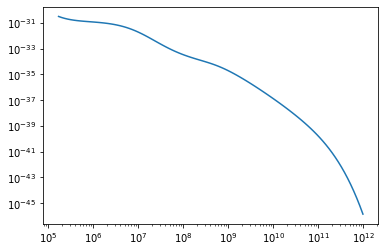

In [16]:
def integrand(energy):
    return (10**gzk_spline(np.log10(energy)))

plt.plot((np.logspace(np.log10(gzk_min/1.2), np.log10(gzk_max*2.), 100))/units.GeV, integrand(np.logspace(np.log10(gzk_min/1.2), np.log10(gzk_max*2.), 100)))
plt.loglog()
plt.show()

## This should integrate to 1-ish now that since we are normalizing##

1.0000001861236076


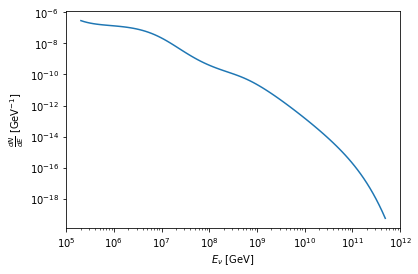

In [17]:
integral = integrate.quad(lambda x: np.exp(x)*integrand(np.exp(x)), np.log(gzk_min), np.log(gzk_max))[0]

def probability(energy):
    return integrand(energy) / integral

integ, error = integrate.quad(lambda x: np.exp(x)*probability(np.exp(x)), np.log(gzk_min), np.log(gzk_max))
print(integ)

# Plot the normalized distribution
plt.plot(np.logspace(np.log10(gzk_min), np.log10(gzk_max), 100)/units.GeV, probability(np.logspace(np.log10(gzk_min), np.log10(gzk_max), 100))*units.GeV)
plt.xlabel(r'$E_{\nu}~\left[\rm{GeV}\right]$')
plt.ylabel(r'$\frac{dN}{dE}~\left[\rm{GeV}^{-1}\right]$')
plt.loglog()
plt.show()

## Make cdf ##

In [18]:
cdf_energies = np.logspace(np.log10(gzk_min), np.log10(gzk_max*1.1), 500)
cdf          = np.array([integrate.quad(lambda x: np.exp(x)*probability(np.exp(x)), np.log(gzk_min), np.log(y))[0] for y in cdf_energies])
mask         = np.where(np.logical_and(cdf>0, cdf<=1))[0]
cdf          = cdf[mask]
cdf_energies = cdf_energies[mask]

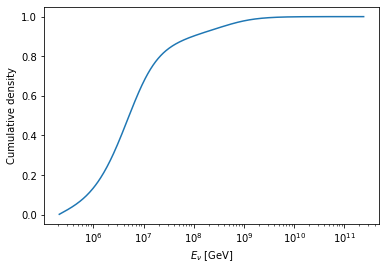

In [19]:
plt.plot(cdf_energies/units.GeV, cdf)
plt.xscale('log')
plt.xlabel(r'$E_{\nu}~\left[\rm{GeV}\right]$')
plt.ylabel(r'Cumulative density')
plt.show()

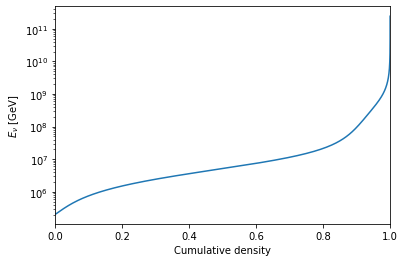

In [20]:
plt.plot(cdf, cdf_energies/units.GeV)
plt.yscale('log')
plt.ylabel(r'$E_{\nu}~\left[\rm{GeV}\right]$')
plt.xlabel(r'Cumulative density')
plt.xlim(0,1)
plt.show()

## Spline cdf ##

In [21]:
cdf_spline = UnivariateSpline(cdf, cdf_energies)

/home/jlazar/.local/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


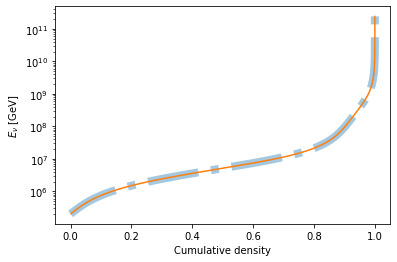

In [22]:
test_cdf_x = np.linspace(0., 1., 5000)

plt.plot(test_cdf_x, cdf_spline(test_cdf_x)/units.GeV, lw = 8., alpha = 0.4, ls = '-.')
plt.plot(cdf, cdf_energies/units.GeV, ls = '-')
plt.ylabel(r'$E_{\nu}~\left[\rm{GeV}\right]$')
plt.xlabel(r'Cumulative density')

plt.yscale('log')


## Make sure you can sample from it and nothing looks weird. (shape of spline should match the bins) ##

In [ ]:
test_log_

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


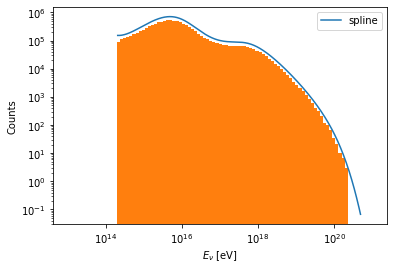

In [24]:
nsamples    = 10000000
random_vals = np.random.uniform(low=0., high=1., size=nsamples)
injected_es = cdf_spline(random_vals)
test_es     = 


# Normalized arbitrarily since we only want to check that the shapes match
plt.plot(np.power(10, test_log_ens), 3e14*nsamples*np.power(10, test_log_ens)*np.power(10., gzk_spline(test_log_ens)), label = 'spline')

h = plt.hist(injected_es, bins = np.logspace(4., 12., 100)*units.GeV)

plt.semilogx()
plt.ylabel(r'Counts')
plt.xlabel(r'$E_{\nu}~\left[\rm{eV}\right]$')

plt.semilogy(nonposy='clip')
plt.legend()
plt.show()


In [12]:
out_f = f'{tr.__path__[0]}/resources/ahlers2010_test.pkl'
with open(out_f, 'wb') as pkl_f:
    pkl.dump(cdf_spline, pkl_f)